# ML_MariaJoseCamacho - Predicci√≥n de Rotaci√≥n de Empleados (Employee Attrition)
## **Paso 1: Entendiendo el problema**


"""
Este proyecto desarrolla un modelo de Machine Learning para predecir qu√© empleados tienen mayor probabilidad de abandonar una empresa ("Attrition"). Se trata de un problema de clasificaci√≥n binaria, cuyo objetivo es anticipar la rotaci√≥n laboral y facilitar decisiones estrat√©gicas en recursos humanos.

Por √∫ltimo agruparemos los diferentes perfiles de los trabajadores mediante modelos no supervisados.
"""


## **Paso 2: Carga de librer√≠as**


In [29]:
import pandas as pd
import numpy as np
import math                                                         
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

## **Paso 3: Carga de datos y viwsualizaci√≥n inicial**
(Selecci√≥n de variables, tratamiento de nulos, escalado si es necesario)


In [2]:
# Cargar los datos de nuestro dataset
file_path = r"C:\Users\marij\Documents\dataset ML\WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [3]:
# Esta es la dimensi√≥n del dataset total
df.shape

(1470, 35)

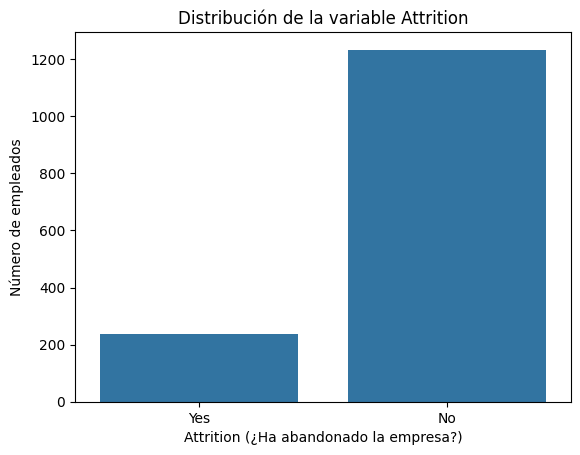

In [4]:
# Visualizamos la variable objetivo
sns.countplot(x='Attrition', data=df)
plt.title('Distribuci√≥n de la variable Attrition')
plt.xlabel('Attrition (¬øHa abandonado la empresa?)')
plt.ylabel('N√∫mero de empleados')
plt.show()

In [5]:
# Conteo de la variable objetivo
print(df['Attrition'].value_counts())

# Porcentaje de cada valor de la variable
print(df['Attrition'].value_counts(normalize=True) * 100)

Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


El dataset est√° desbalanceado (~16% abandonos), por lo que priorizaremos m√©tricas como recall.

### üìÑ Descripci√≥n de las variables del dataset

| Columna                     | Descripci√≥n                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **Age**                     | Edad del empleado.                                                          |
| **Attrition**               | Si el empleado ha abandonado la empresa (`Yes`) o no (`No`).               |
| **BusinessTravel**          | Frecuencia con la que el empleado viaja por trabajo.                        |
| **Department**              | Departamento en el que trabaja el empleado (Ventas, I+D, RRHH).             |
| **DistanceFromHome**        | Distancia (en millas) desde su casa al trabajo.                             |
| **Education**               | Nivel educativo (1=Menor, 5=Mayor).                                         |
| **EducationField**          | √Årea de formaci√≥n (Ciencias, Marketing, Medicina, etc.).                    |
| **EnvironmentSatisfaction** | Grado de satisfacci√≥n con el entorno laboral (1 a 4).                      |
| **Gender**                  | G√©nero del empleado.                                                        |
| **JobRole**                 | Cargo o puesto de trabajo espec√≠fico.                                       |
| **JobSatisfaction**         | Grado de satisfacci√≥n con su trabajo (1 a 4).                               |
| **MaritalStatus**           | Estado civil (Soltero, Casado, Divorciado).                                |
| **MonthlyIncome**           | Ingreso mensual.                                                            |
| **NumCompaniesWorked**      | N√∫mero de empresas anteriores en las que ha trabajado.                      |
| **OverTime**                | Si realiza horas extra (`Yes` o `No`).                                      |
| **PercentSalaryHike**       | Porcentaje del √∫ltimo aumento salarial.                                    |
| **StockOptionLevel**        | Nivel de participaci√≥n accionarial.                                        |
| **TotalWorkingYears**       | A√±os totales de experiencia laboral.                                        |
| **TrainingTimesLastYear**   | N√∫mero de formaciones completadas el √∫ltimo a√±o.                           |
| **WorkLifeBalance**         | Equilibrio entre vida personal y trabajo (1=Malo, 4=Excelente).             |
| **YearsAtCompany**          | A√±os que lleva en la empresa.                                              |
| **YearsInCurrentRole**      | A√±os en su puesto actual.                                                  |
| **YearsSinceLastPromotion** | A√±os desde la √∫ltima promoci√≥n.                                            |
| **YearsWithCurrManager**    | A√±os trabajando con el actual supervisor.                                   |


## **Paso 4: An√°lisis exploratorio (Mini EDA)**

En este paso exploramos la estructura y caracter√≠sticas principales del dataset para entender mejor la variable objetivo y las posibles relaciones con otras variables.



In [6]:
# Valores nulos
print(df.isnull().sum().sort_values(ascending=False).head())

Age               0
Attrition         0
BusinessTravel    0
DailyRate         0
Department        0
dtype: int64


In [7]:
# Estad√≠sticas generales
df.describe()

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335                 1.093082    20.329428        0.711561   
min          1.000000                 1.000000    30.000000        1.000000   
25%        491.250000                 2.000000    48.000000        2.000000   
50%       1020.500000                 3.000000    66.000000        3.000000   
75%       1555.750000                 4.000000    83.750000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  ...  RelationshipSatisfaction  StandardHours  \
count  1470.000000  ...               1470.000000         1470.0   
mean      2.063946  ...                  2.712245           80.0   
std       1.106940  ...                  1.081209            0.0   
min       1.000000  ...                  1.000000           80.0   
25%       1.000000  ...                  2.000000           80.0   
50%       2.000000  ...                  3.000000           80.0   
75%       3.000000  ...                  4.000000           80.0   
max       5.000000  ...                  4.000000           80.0   

       StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
count       1470.000000        1470.000000            1470.000000   
mean           0.793878          11.279592               2.799320   
std            0.852077           7.780782               1.289271   
min            0.000000           0.000000               0.000000   
25%            0.000000           6.000000               2.000000   
50%            1.000000          10.000000               3.000000   
75%            1.000000          15.000000               3.000000   
max            3.000000          40.000000               6.000000   

       WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
count      1470.000000     1470.000000         1470.000000   
mean          2.761224        7.008163            4.229252   
std           0.706476        6.126525            3.623137   
min           1.000000        0.000000            0.000000   
25%           2.000000        3.000000            2.000000   
50%           3.000000        5.000000            3.000000   
75%           3.000000        9.000000            7.000000   
max           4.000000       40.000000           18.000000   

       YearsSinceLastPromotion  YearsWithCurrManager  
count              1470.000000           1470.000000  
mean                  2.187755              4.123129  
std                   3.222430              3.568136  
min                   0.000000              0.000000  
25%                   0.000000              2.000000  
50%                   1.000000              3.000000  
75%                   3.000000              7.000000  
max                  15.000000             17.000000  

[8 rows x 26 columns]

In [8]:
# Correlaci√≥n con variable objetivo binarizada
df["Attrition_bin"] = df["Attrition"].map({"Yes": 1, "No": 0})
correlaciones = df.corr(numeric_only=True)["Attrition_bin"].sort_values(ascending=False)
print(correlaciones)

Attrition_bin               1.000000
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
EmployeeNumber             -0.010577
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
EmployeeCount                    NaN
StandardHours                    NaN
N

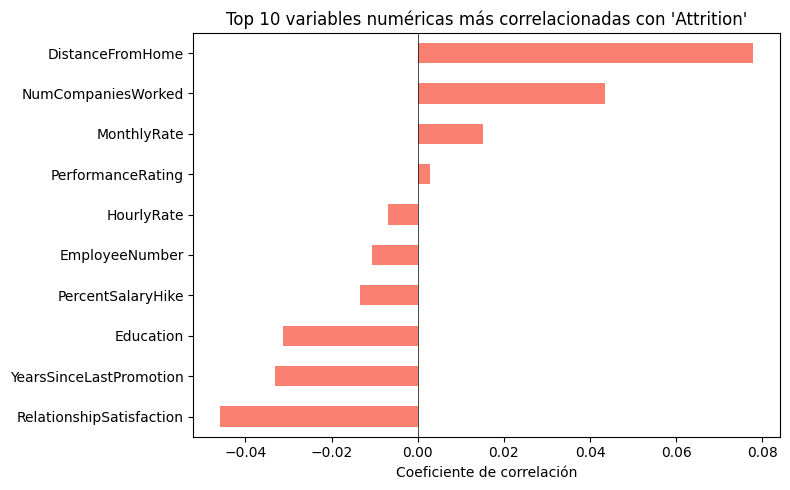

In [9]:
# Visualizamos las 10 variables num√©ricas m√°s correlacionadas con la rotaci√≥n
plt.figure(figsize=(8, 5))
correlaciones.drop("Attrition_bin").head(10).plot(kind='barh', color='salmon')
plt.title("Top 10 variables num√©ricas m√°s correlacionadas con 'Attrition'")
plt.xlabel("Coeficiente de correlaci√≥n")
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Tras analizar las correlaciones num√©ricas con la variable objetivo (`Attrition_bin`), observamos que algunas variables presentan coeficientes muy cercanos a cero, lo que indica que tienen poca o ninguna relaci√≥n lineal con la rotaci√≥n de empleados.

Variables como `EmployeeNumber`, `PerformanceRating`, `HourlyRate` o `PercentSalaryHike` muestran una correlaci√≥n muy baja o negativa con `Attrition_bin`. Por ello, en el siguiente paso procederemos a **descartar estas variables consideradas poco relevantes** para mejorar la eficiencia y la interpretabilidad del modelo.

Esta eliminaci√≥n se realizar√° antes del entrenamiento, asegurando que el modelo solo trabaje con variables con potencial predictivo.



In [10]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_bin'],
      dtype='object')

In [11]:
# Variables num√©ricas que eliminaremos por baja correlaci√≥n o poca variabilidad
cols_a_eliminar = [
    'EmployeeCount',       # constante (1 para todos)
    'StandardHours',       # constante (80 para todos)
    'EmployeeNumber',      # ID √∫nico, no aporta info √∫til
    'Over18'               # si existe, generalmente constante
]

# Algunas variables con correlaci√≥n casi nula o negativa pueden eliminarse tambi√©n:
cols_baja_corr = [
    'PerformanceRating', 
    'HourlyRate', 
    'PercentSalaryHike', 
    'MonthlyRate', 
    'DailyRate', 
    'TrainingTimesLastYear'
]

cols_a_eliminar += cols_baja_corr

# Eliminamos esas columnas del dataframe para el an√°lisis/modelado posterior
dfnew = df.drop(columns=cols_a_eliminar)

print(f"Columnas eliminadas: {cols_a_eliminar}")
dfnew.shape

Columnas eliminadas: ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18', 'PerformanceRating', 'HourlyRate', 'PercentSalaryHike', 'MonthlyRate', 'DailyRate', 'TrainingTimesLastYear']


(1470, 26)

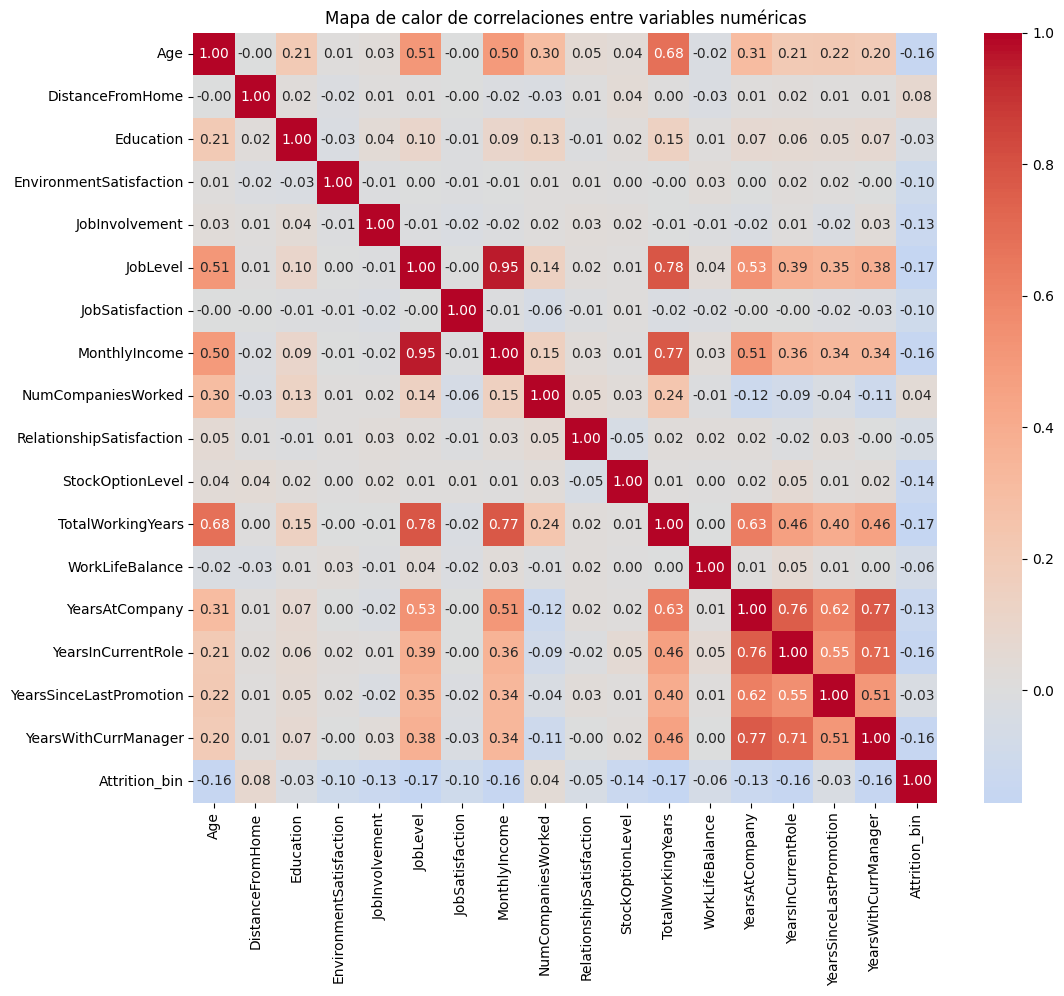

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(dfnew.select_dtypes(include=['int64', 'float64']).corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones entre variables num√©ricas")
plt.show()

### Interpretaci√≥n del mapa de calor

- Las variables m√°s asociadas con la rotaci√≥n (`Attrition_bin`) son:
  - **JobLevel**, **MonthlyIncome**, **TotalWorkingYears**, **YearsAtCompany**, **JobInvolvement**, todas con coeficientes negativos, lo que indica que a mayor antig√ºedad, implicaci√≥n o salario, menor probabilidad de abandono.
  
- Se observa **colinealidad** entre algunas variables:
  - `MonthlyIncome`, `JobLevel` y `TotalWorkingYears` est√°n altamente correlacionadas (coeficientes > 0.75).
  - `YearsWithCurrManager` y `YearsInCurrentRole` tambi√©n.
  
Estas relaciones deben considerarse al seleccionar variables o aplicar t√©cnicas de reducci√≥n de dimensionalidad.


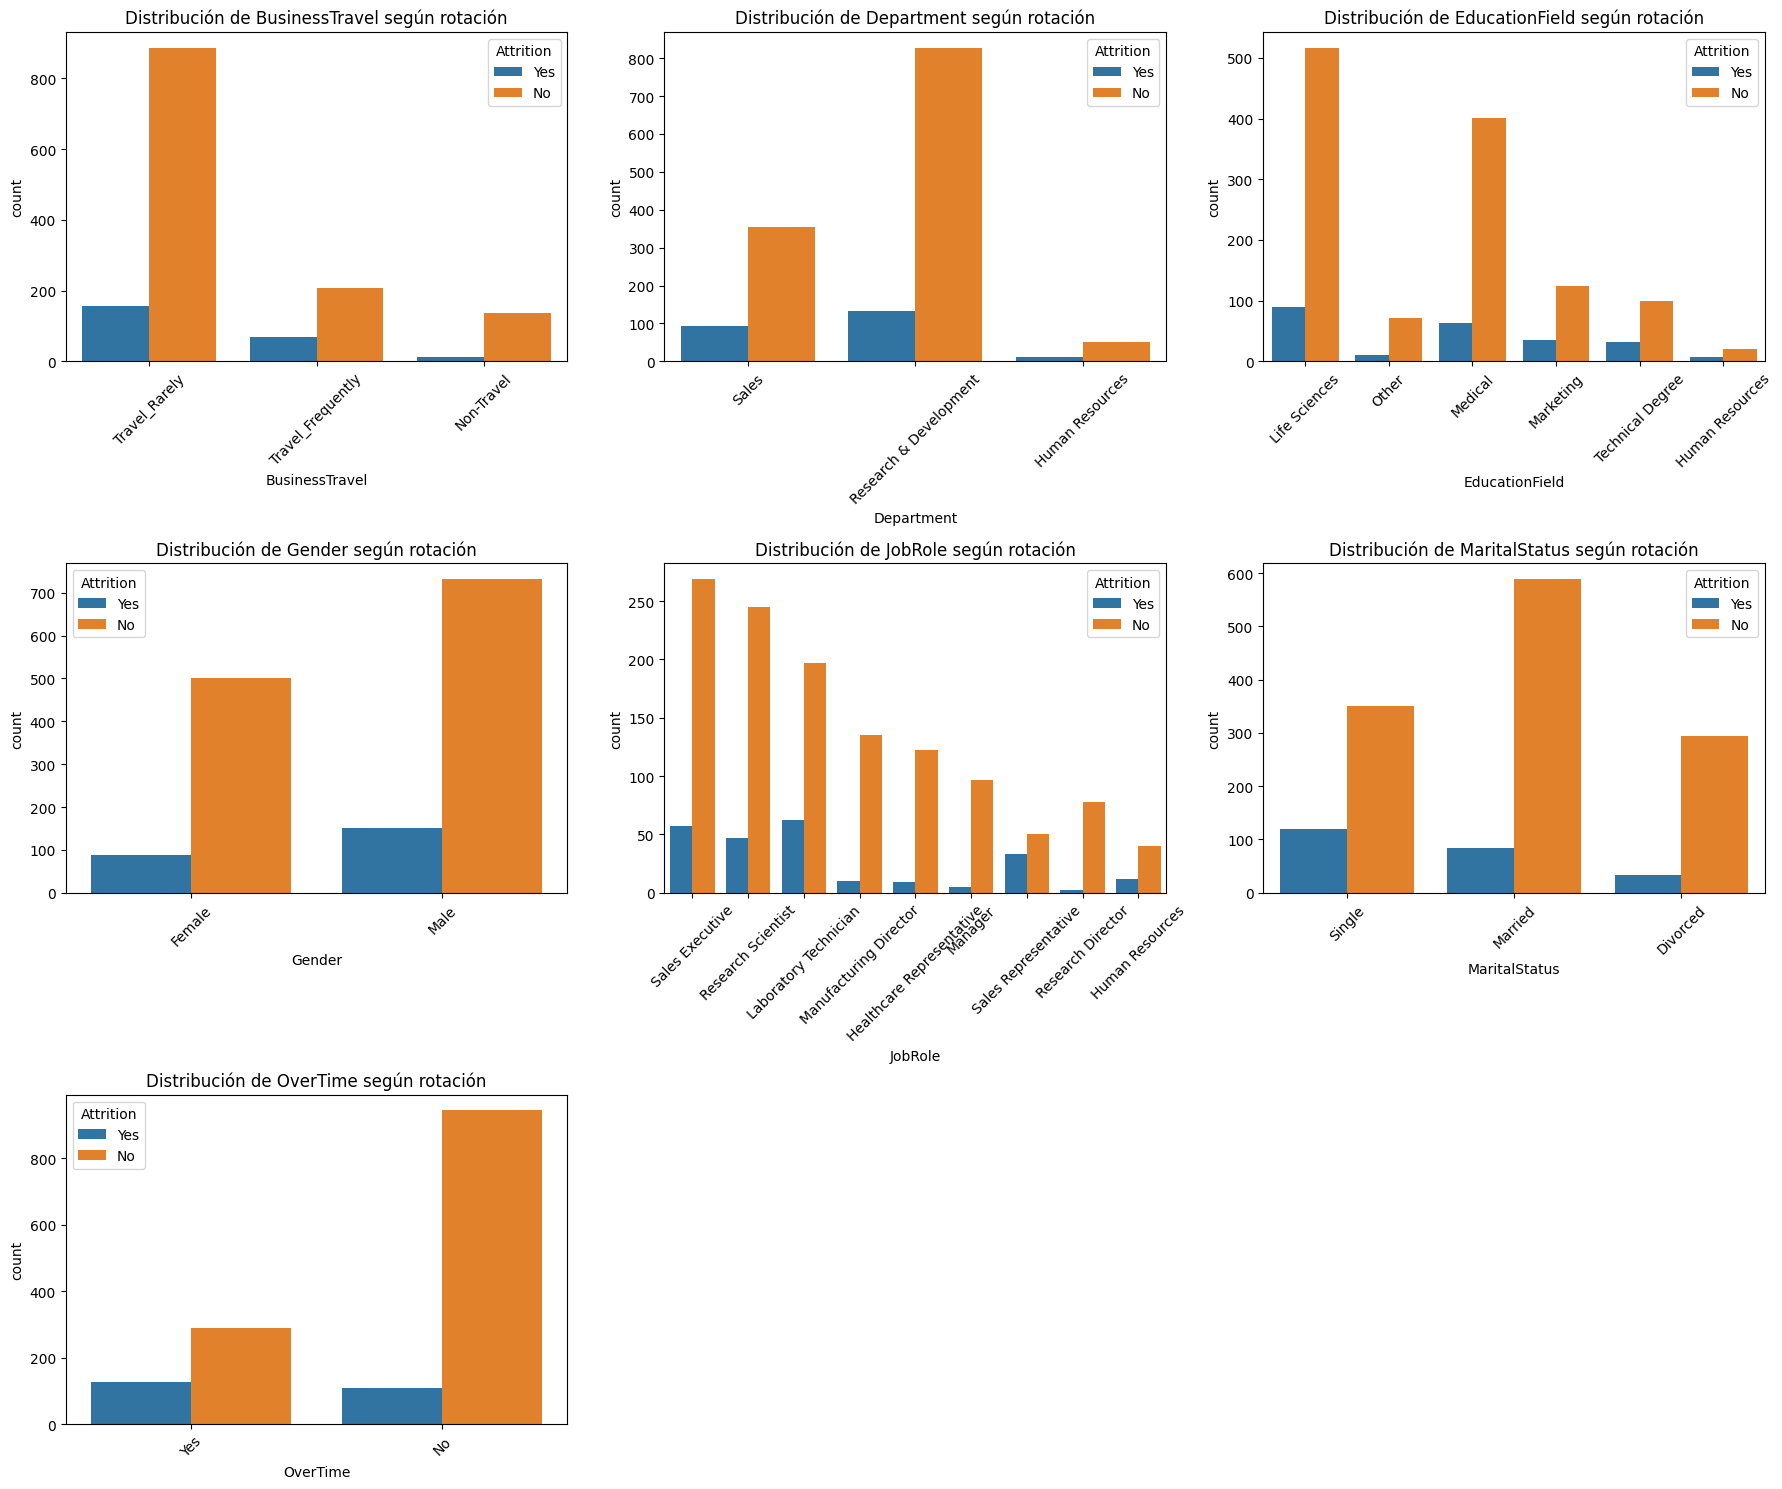

In [13]:
# Columnas categ√≥ricas excluyendo la variable objetivo
categorical_cols = dfnew.select_dtypes(include=['object']).columns.drop('Attrition')

# Definir n√∫mero de columnas (por est√©tica)
n_cols = 3
n_plots = len(categorical_cols)
n_rows = (n_plots + n_cols - 1) // n_cols  # redondeo hacia arriba sin usar math.ceil

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Visualizar
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Attrition', data=dfnew, ax=axes[i])
    axes[i].set_title(f'Distribuci√≥n de {col} seg√∫n rotaci√≥n')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar subplots vac√≠os
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Se observan diferencias claras en la distribuci√≥n de la variable `Attrition` seg√∫n varias variables categ√≥ricas.
- Empleados que hacen horas extra (`OverTime = Yes`), que viajan con frecuencia (`BusinessTravel = Travel_Frequently`) o que est√°n solteros (`MaritalStatus = Single`) presentan una mayor proporci√≥n de abandono.
- Algunos roles (`JobRole`) y departamentos tambi√©n muestran tendencias espec√≠ficas en relaci√≥n con la rotaci√≥n.
- Estos patrones visuales sugieren que ciertas categor√≠as est√°n asociadas con un mayor riesgo de abandono, lo que justifica que la incluyamos para el modelado posterior.


In [ ]:
# Test Chi2 para las variables categoricas
for col in categorical_cols:
    tabla = pd.crosstab(dfnew[col], dfnew['Attrition'])
    chi2, p, dof, expected = chi2_contingency(tabla)
    print(f"‚Ü™ {col}: p-valor = {p:.4f}")
    if p < 0.05:
        print("   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition")
    else:
        print("   ‚úñ No hay asociaci√≥n significativa con Attrition")
    print("-" * 60)

‚Ü™ BusinessTravel: p-valor = 0.0000
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ Department: p-valor = 0.0045
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ EducationField: p-valor = 0.0068
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ Gender: p-valor = 0.2906
   ‚úñ No hay asociaci√≥n significativa con Attrition
------------------------------------------------------------
‚Ü™ JobRole: p-valor = 0.0000
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ MaritalStatus: p-valor = 0.0000
   ‚úî Asociaci√≥n estad√≠sticamente significativa con Attrition
------------------------------------------------------------
‚Ü™ OverTime: p-valor = 0.0000
   ‚úî Asociaci√≥n est

In [15]:
# Eliminamos la variable 'Gender' por no aportar informaci√≥n relevante al target
dfnew = dfnew.drop(columns='Gender')

# Confirmamos
print("Gender eliminado. Columnas actuales:")
dfnew.columns.tolist()

Gender eliminado. Columnas actuales:


['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'OverTime',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_bin']

### Conclusiones del test Chi-cuadrado

El test Chi-cuadrado confirma que **la mayor√≠a de las variables categ√≥ricas analizadas presentan una asociaci√≥n estad√≠sticamente significativa con la rotaci√≥n de empleados (`Attrition`)**:

- ‚úî `BusinessTravel`, `Department`, `EducationField`, `JobRole`, `MaritalStatus` y `OverTime` tienen un **p-valor < 0.05**, lo que indica que las diferencias observadas en sus categor√≠as respecto a la rotaci√≥n **no son aleatorias**.
- ‚úñ La variable `Gender`, sin embargo, **no muestra una asociaci√≥n significativa**, lo que sugiere que **el g√©nero no influye directamente en la decisi√≥n de abandonar la empresa** en este dataset.

Estos resultados respaldan la elecci√≥n de las variables categ√≥ricas m√°s relevantes para incluir en el preprocesamiento y posterior modelado.


In [34]:
# --------------------------
# 1. Definici√≥n de columnas categ√≥ricas y num√©ricas
# --------------------------
target = 'Attrition'

cat_features = []
num_features = []

for col in dfnew.columns:
    if col == target:
        continue
    if dfnew[col].dtype == 'object' or dfnew[col].dtype.name == 'category':
        cat_features.append(col)
    elif pd.api.types.is_numeric_dtype(dfnew[col]):
        num_features.append(col)

In [30]:

def plot_numeric_distributions(df, num_features, target, cols=3, kde=True):
    rows = math.ceil(len(num_features) / cols)
    plt.figure(figsize=(cols * 5, rows * 4))

    for i, col in enumerate(num_features):
        if df[col].nunique() <= 1:
            continue  # salta columnas constantes

        plt.subplot(rows, cols, i + 1)
        sns.histplot(
            data=df,
            x=col,
            hue=target,
            kde=kde,
            stat='density',
            common_norm=False,
            palette='Set2',
            alpha=0.6
        )
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel('Densidad')

    plt.tight_layout()
    plt.show()

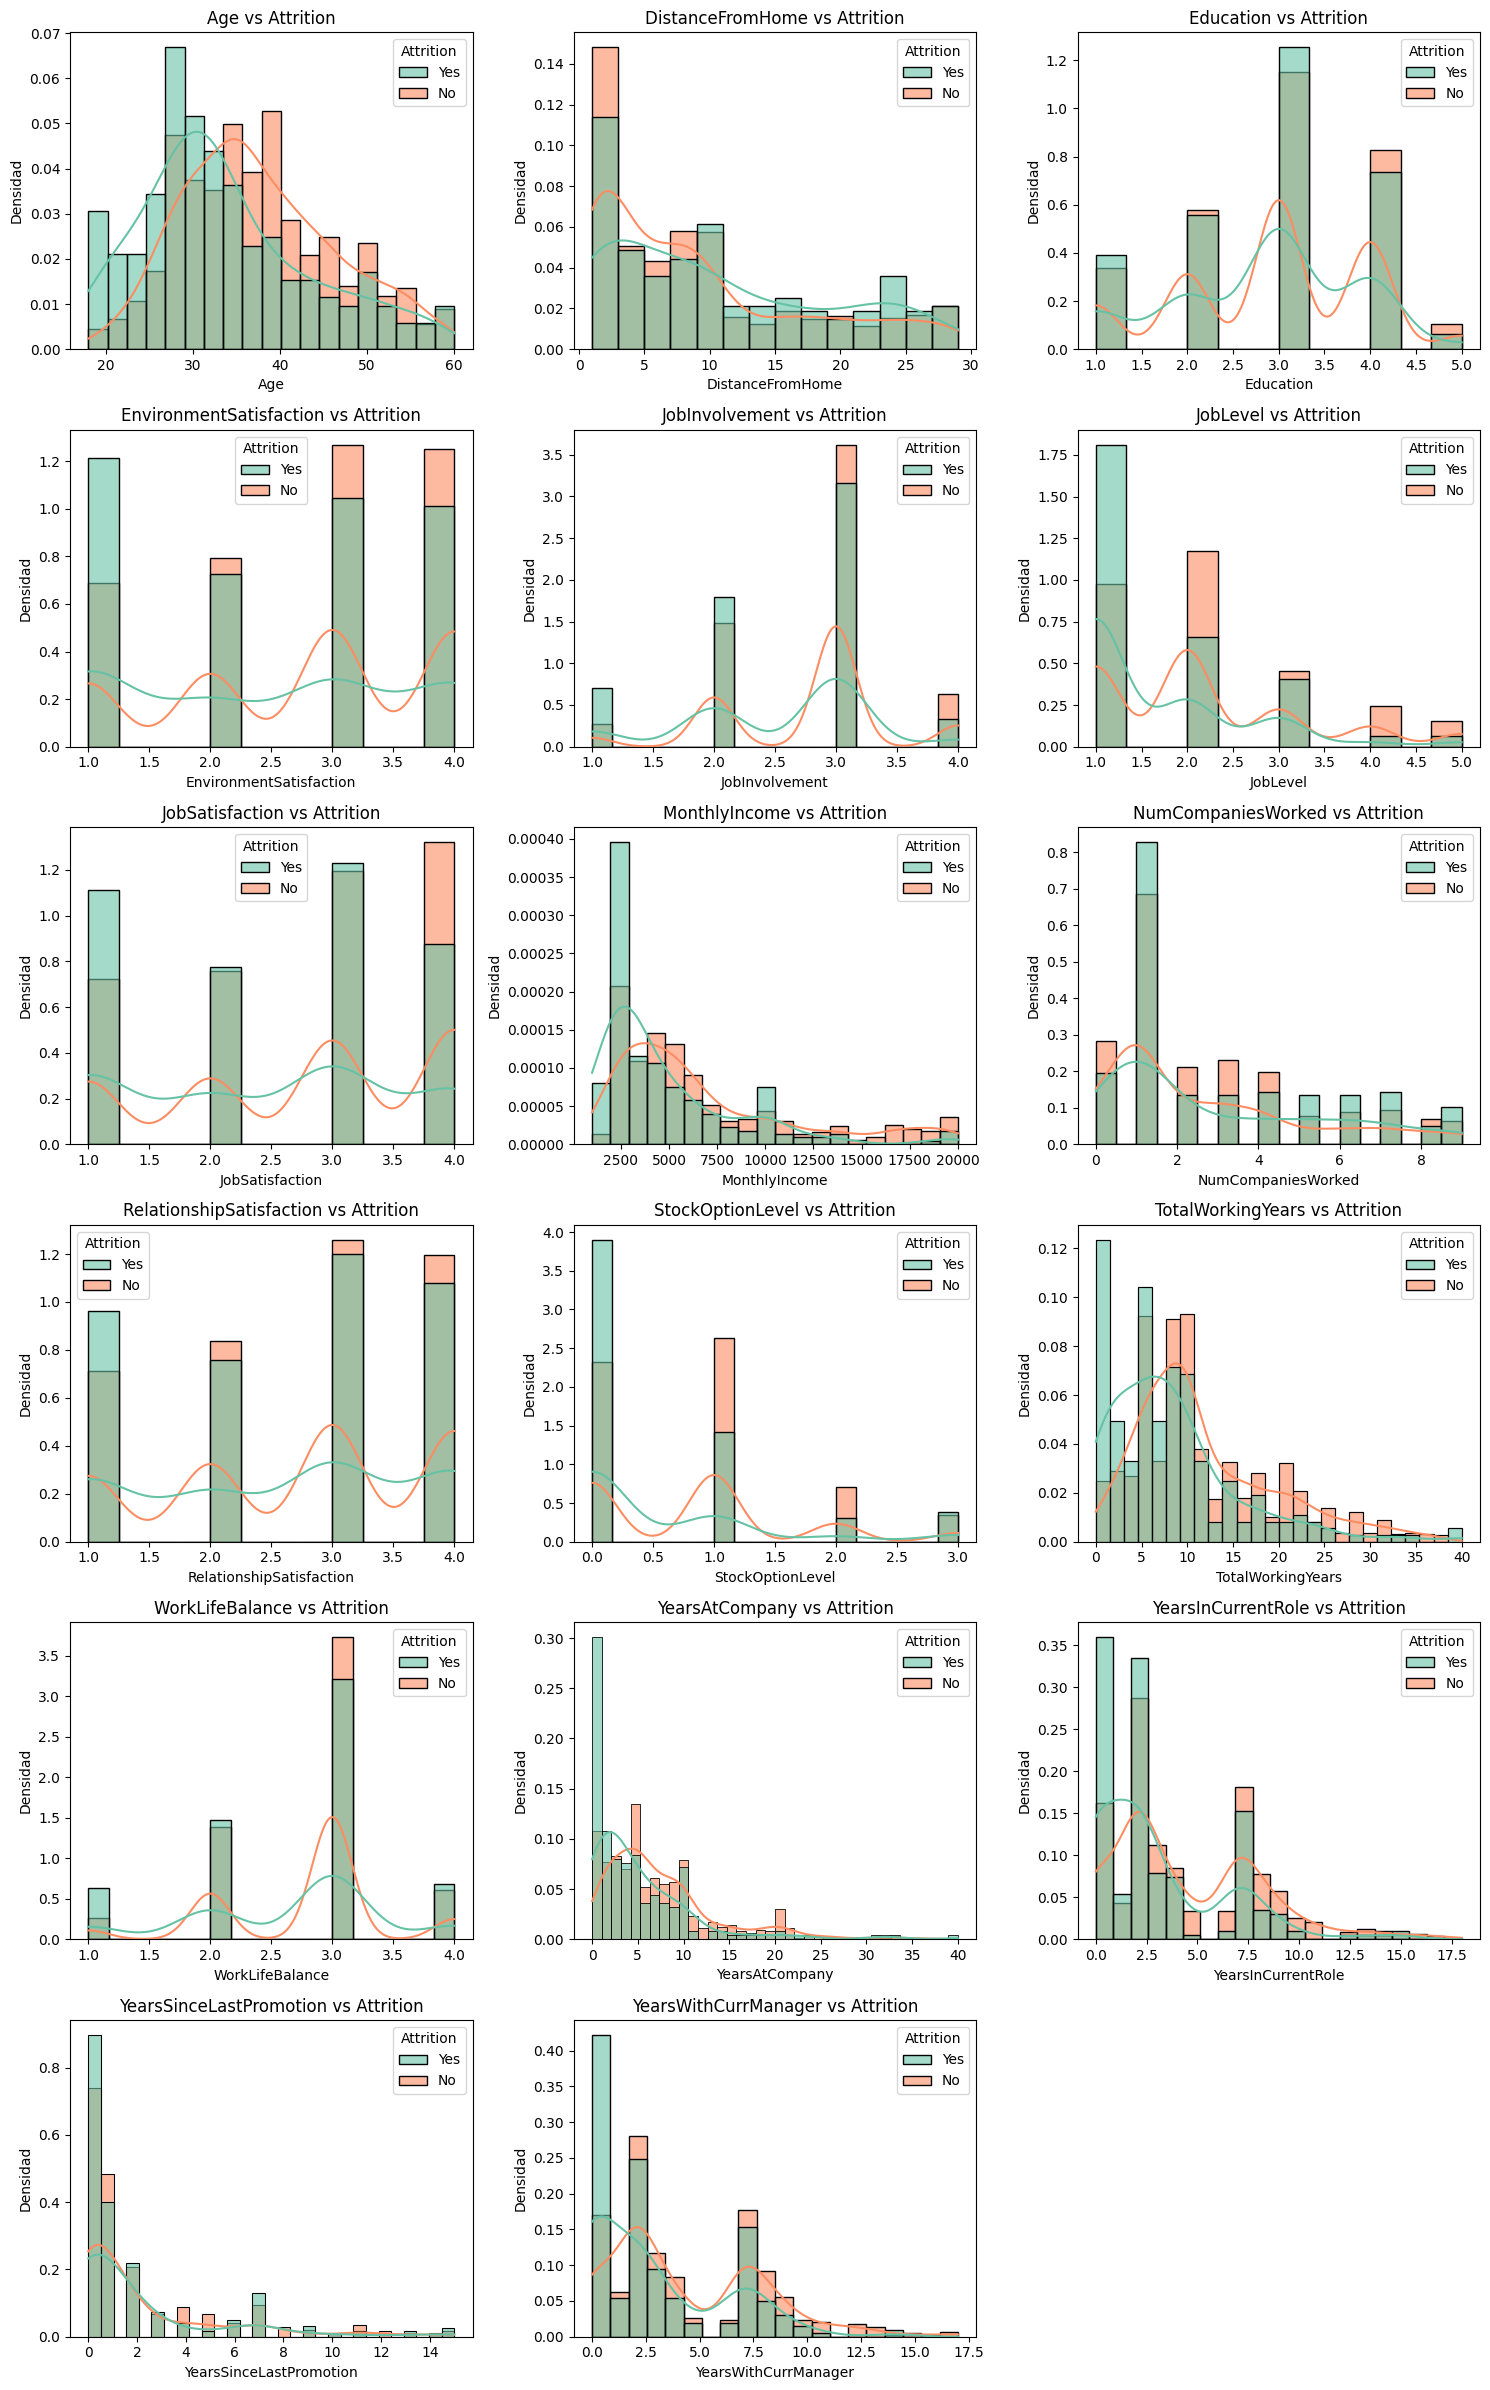

In [32]:
num_features = dfnew.select_dtypes(include=['int64', 'float64']).drop(columns='Attrition_bin').columns
plot_numeric_distributions(dfnew, num_features=num_features, target='Attrition')

## **Paso 5: Reducci√≥n de dimensiones (opcional)**
(PCA si decides usarlo para visualizaci√≥n o clustering)

## **Paso 6: Clustering**
(Entrenamiento del modelo: k-means, n√∫mero √≥ptimo de clusters, silhouette score‚Ä¶)

## **Paso 7: Interpretaci√≥n de los grupos**
(Describir los perfiles encontrados, visualizarlos en 2D si usaste PCA o t-SNE)

## **Paso 8: Guardado del modelo**
(Exportar modelo entrenado en formato `.joblib` en `/src/models`)

## **Paso 9: Conclusiones**
(Resumen del proyecto y aplicaciones reales del an√°lisis)